<a href="https://colab.research.google.com/github/joanall/Hands-On-Epigenome-Wide-Analysis-EWAS-/blob/main/ewas_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-on Data EWAS Analysis Tutorial**  

Joana Llauradó, Predoctoral Researcher at the Barcelona Institute for Global Health (ISGlobal).

Mariona Bustamante, Senior Research Scientist at the Barcelona Institute for Global Health (ISGlobal).


**Objective:** his hands-on exercise focuses on the analysis phase of an Epigenome-Wide Association Study (EWAS). Using preprocessed DNA methylation data, participants will learn how to identify associations between an environmental exposure—such as smoking—and methylation levels across the genome.


**Description:** During this practical, we will perform EWAS analysis and basic downstream interpretation to gain biological insight from the results. Participants will learn how to run association models, correct for multiple testing, visualize significant findings (e.g., using Manhattan and QQ plots), and interpret the top CpG sites and enriched pathways related to the exposure of interest.

**Based on/adapted from** Previous course Summer School in Global Health 2023-EWAS [https://github.com/isglobal-brge/course_methylation?tab=readme-ov-file]

**Considerations**
* The data quality control (QC) step will not be assessed in this session. However, participants can explore QC independently using the example code provided [here: insert link], which demonstrates h ow to perform standard preprocessing and QC steps.

* Public data from [link] It must be noted that this data is public and has been revied/selcetd to be able tor un this nalaysis in a short period of time. Ewas data usually is upt to XXXX GB and a compute with enough memory or clsuter is nneded to run this nalaysis. Also the time needed is higher than the one for this Hands-on.

•
Recommendations for the design and analysis of epigenome wide association studies
https://clinicalepigeneticsjournal.biomedcentral.com/articles/10.1186/s13148 021 01200 8
•

•
Meffil : efficient normalization and analysis of very large DNA methylation datasets (ADDED
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6247925/
•
Orchestrating high throughput genomic analysis with Bioconductor
https://www.nature.com/articles/nmeth.3252

**Reminder: Introduction to NoteBook**
Within this notebook (NoteBook), you will be guided step by step from loading a dataset to performing analysis of its content.

The Jupyter (Python) notebook is an approach that combines text blocks (like this one) together with code blocks or cells. The great advantage of this type of cell is its interactivity, as they can be executed to check the results directly within them. Very important: the order of instructions is fundamental, so each cell in this notebook must be executed sequentially. If any are omitted, the program may throw an error, so you should start from the beginning if in doubt.

First of all:

It is very very important that at the start you select "Open in draft mode" (draft mode), at the top left. Otherwise, it will not allow you to execute any code block, for security reasons. When the first of the blocks is executed, the following message will appear: "Warning: This notebook was not created by Google.". Do not worry, you should trust the content of the notebook (NoteBook) and click "Run anyway".

Let’s go!

Click the "play" button on the left side of each code cell. Lines of code that begin with a hashtag (#) are comments and do not affect the execution of the program.

You can also click on each cell and press "ctrl+enter" (cmd+enter on Mac).

Each time you run a block, you will see the output just below it. The information is usually always related to the last instruction, along with all the print() commands in the code.

## **INDEX**
1. [Installation of the R environment and required libraries for EWAS](#install-libraries)
2. [Load data](#load-data)
3. [Descriptive analysis](#descriptive)   
4. [Epigenome wide association analysis](#association)
3. [Other tutorials for previours-further steps](#tutorials)   
4. [Acknowledgement](#acknowledgement)   


## **1. Installation of the R Environment and Libraries for EWAS Analysis** <a name="install-libraries"></a>

Below, we install/load the libraries necessary for this session. In the context of exposome analysis, R libraries offer us a much more convenient way to process, manipulate, and analyze the data. Some of these libraries: `tidyverse`, `name_library`  
  
The installation of R in our Google Colab environment will be carried out in the following code block. It should be remembered that all library installations we perform in the Google Colab environment will only remain active for a few hours, after which the installed libraries are removed. Therefore, it will be necessary for you to re-run the library installation code in this section whenever you need to run the notebook again after this time.

Before starting, make sure the required R packages are available. We recommend installing the libraries **30 minutes** before the start of the session❗❗❗

* **On your local machine (RStudio, etc.)**: you usually install once, then just load them in each new R session.

* **In Google Colab:** the runtime is temporary, when it resets or disconnects, previously installed packages can disappear. Therefore we need to install each time at the start of every session.

In [57]:
# Estimated execution time:45 minutes approx.
t0 <- Sys.time()

####################################### INSTALLING ####################################################

# Make sure Bioc repos are used (so CRAN doesn't override them)
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
options(repos = BiocManager::repositories())

bioc_pkgs <- c("GenomicRanges", "GEOquery","Biobase","karyoploteR")

cran_pkgs <- c("qqman", "ggplot2", "ggrepel", "tableone")

# other we may need: "IlluminaHumanMethylation450kanno.ilmn12.hg19", "clusterProfiler",
#                       "org.Hs.eg.db", "ReactomePA", "enrichplot", metafor, reshape plyr

BiocManager::install(bioc_pkgs, ask = FALSE, update = FALSE)

to_install_cran <- setdiff(cran_pkgs, rownames(installed.packages()))
if (length(to_install_cran)) {
  install.packages(to_install_cran)
}



# meffil from GitHub (lighter than devtools)
if (!requireNamespace("remotes", quietly = TRUE)) install.packages("remotes")
remotes::install_github("perishky/meffil", upgrade = "never")  # use force = TRUE to reinstall



####################################### LOADING ####################################################
# Load Biococneductor libraries
library(BiocManager)
library(GenomicRanges) # prepare db for Manhattan plot
library(GEOquery)
library(Biobase)# to be able to access and modify data in the ExpressionSet
library(karyoploteR) #  Manhattan plot

# Load CRAN libraries
library(qqman)
library(ggplot2)# plots
library(ggrepel)
library(tableone)

# Alternative: invisible(lapply(c(bioc_pkgs, cran_pkgs), require, character.only = TRUE))

library(meffil) # to run the EWAS

cat(sprintf("Execution time: %.1f minutes\n", as.numeric(difftime(Sys.time(), t0, units = "mins"))))


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    BioCsoft: https://bioconductor.org/packages/3.21/bioc
    BioCann: https://bioconductor.org/packages/3.21/data/annotation
    BioCexp: https://bioconductor.org/packages/3.21/data/experiment
    BioCworkflows: https://bioconductor.org/packages/3.21/workflows
    BioCbooks: https://bioconductor.org/packages/3.21/books
    CRAN: https://cran.rstudio.com

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    BioCsoft: https://bioconductor.org/packages/3.21/bioc
    BioCann: https://bioconductor.org/packages/3.21/data/annotation
    BioCexp: https://bioconductor.org/packages/3.21/data/experiment
    BioCworkflows: https://bioconductor.org/packages/3.21/workflows
    BioCbooks: https://bioconductor.org/packages/3.21/books
    CR

Execution time: 0.1 minutes


**Tip:** if you want to learn more about any package or function, check the built-in docs. Use `help()` for functions/topics, and `vignette()` for longer, tutorial-style guides.

In [7]:
help(package="GenomicRanges")

In [3]:
vignette(package="GenomicRanges")

In [8]:
?GenomicRanges

## **2. Load the Data** <a name="load-data"></a>

For this practical we’ll use public methylation data derived from the GEO study GSE42861 (Epigenome-wide DNA methylation in blood). To make the tutorial fast and Colab/GitHub-friendly, we’ve prepared a lightweight subset where we keep a subset of CpGs and round beta values to 3 decimals. This keeps the file small enough for GitHub and runs quickly in Colab, while preserving the look and feel of real EWAS data.

Original public dataset (reference): GSE42861 on GEO.

Workshop dataset (ready-to-use): a preprocessed ExpressionSet hosted in this repo.

How to use it

* Option 1 (this tutorial): load the data (from GitHub).

* Option 2 (not in this practice): uncomment the GEO download code to fetch the original public data and work end-to-end. Note that full methylation data are large and may take longer to download/process.

In [58]:
input_data_url <- "https://raw.githubusercontent.com/joanall/Hands-On-Epigenome-Wide-Analysis-EWAS-/main/data/GSE42861_norm_cohort1_round3.xz.rds"

tmp <- tempfile(fileext = ".rds")
download.file(input_data_url, destfile = tmp, mode = "wb")  # binary mode
input_data <- readRDS(tmp)

### 2.1 Type of InputData: ExpressionSet

Using `str()` we can get a quick description of what’s inside our data object.
We’re working with an **ExpressionSet** object (from Biobase), which is  derived after preprocessing with the meffil package.

An `ExpressionSet` stores several coordinated tables (slots):

* **Expression data:** probe-by-sample matrix of methylation values (betas) — stored in `assayData` and accessed with `exprs()`.

* **Phenotype data:** sample-level traits/covariates (age, sex, smoking, cell counts) — stored in `phenoData` and accessed with `pData()` or `phenoData()`.

* **Feature (probe) data:** probe-level information/annotation — stored in `featureData` and accessed with `fData()`.
* **Metadata:** `experimentData`, `protocolData`, and an `annotation`.

In [59]:
str(input_data)

Formal class 'ExpressionSet' [package "Biobase"] with 7 slots
  ..@ experimentData   :Formal class 'MIAME' [package "Biobase"] with 13 slots
  .. .. ..@ name             : chr ""
  .. .. ..@ lab              : chr ""
  .. .. ..@ contact          : chr ""
  .. .. ..@ title            : chr ""
  .. .. ..@ abstract         : chr ""
  .. .. ..@ url              : chr ""
  .. .. ..@ pubMedIds        : chr ""
  .. .. ..@ samples          : list()
  .. .. ..@ hybridizations   : list()
  .. .. ..@ normControls     : list()
  .. .. ..@ preprocessing    : list()
  .. .. ..@ other            : list()
  .. .. ..@ .__classVersion__:Formal class 'Versions' [package "Biobase"] with 1 slot
  .. .. .. .. ..@ .Data:List of 2
  .. .. .. .. .. ..$ : int [1:3] 1 0 0
  .. .. .. .. .. ..$ : int [1:3] 1 1 0
  .. .. .. .. ..$ names: chr [1:2] "MIAxE" "MIAME"
  ..@ assayData        :<environment: 0x59caafc44c18> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  .. .. 

# 2.2 General Descriptives

Using this common accesor we can quickly inspect the dataset: size, key phenotypes, and basic distributions.


In [60]:
# Get mehtyl and pheno data
methyl <- Biobase::exprs(input_data)   # CpGs x samples
pheno  <- Biobase::pData(input_data)   # samples x covariates

# Dimensions
cat("CpGs:", nrow(methyl), " | Samples:", ncol(methyl), "\n")

CpGs: 37842  | Samples: 294 


In [61]:
head(pheno)

,Celltype,Age,Sex,Smoking,Bcell,CD4T,CD8T,Mono,Neu,NK
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1051533,PBL,55,M,current,0.05776289,0.1247670,0.1504868,0.06491293,0.5358684,0.12265971
GSM1051534,PBL,37,M,never,0.04361658,0.1745954,0.1103084,0.08771190,0.5912413,0.03415583
GSM1051536,PBL,59,M,former,0.08652383,0.2567549,0.1127774,0.10776822,0.3831736,0.11577982
GSM1051537,PBL,49,M,former,0.05720053,0.1568934,0.1046096,0.04774298,0.6380837,0.04546749
GSM1051538,PBL,47,M,former,0.03323647,0.2066790,0.0545260,0.08125238,0.5832287,0.08392876
GSM1051539,PBL,69,M,never,0.03967494,0.1508131,0.1469707,0.09975280,0.5362770,0.07770261


We can make quick descriptives

In [62]:
# See available phenotype columns
print(colnames(pheno))

 [1] "Celltype" "Age"      "Sex"      "Smoking"  "Bcell"    "CD4T"    
 [7] "CD8T"     "Mono"     "Neu"      "NK"      


Some text

In [63]:
# Choose variables to include in the descriptives
cont_vars <- intersect(c("Age"), names(pheno))
cat_vars  <- intersect(c("Sex","Smoking","Batch","Array","Slide","Plate"), names(pheno))
vars <- c(cont_vars, cat_vars)

# Build Table 1
tab1 <- CreateTableOne(vars = vars,
                       data = pheno,
                       factorVars = cat_vars)
print(tab1, showAllLevels = TRUE, quote = FALSE, noSpaces = TRUE)

                 
                  level   Overall      
  n                       294          
  Age (mean (SD))         53.57 (11.04)
  Sex (%)         F       210 (71.4)   
                  M       84 (28.6)    
  Smoking (%)     current 89 (30.3)    
                  former  106 (36.1)   
                  never   99 (33.7)    


In [15]:
tab1_df <- as.data.frame(
  print(tab1, showAllLevels = TRUE, quote = FALSE,
  noSpaces = TRUE, printToggle = FALSE)
)
# Save table
print(getwd())
save_to <- file.path(getwd(),"Table1_overall.csv")
write.csv(tab1_df, save_to, row.names = TRUE)


[1] "/content"


In [64]:
# Stratified table smokers non-smkoers
strata_var <- "Smoking"

tab1_strata <- CreateTableOne(vars = vars,
                              strata = strata_var,
                              data = pheno,
                              factorVars = cat_vars)
print(tab1_strata, showAllLevels = TRUE, quote = FALSE, noSpaces = TRUE)

                 Stratified by Smoking
                  level   current       former       never         p      test
  n                       89            106          99                       
  Age (mean (SD))         52.73 (10.62) 55.06 (9.79) 52.75 (12.52) 0.225      
  Sex (%)         F       66 (74.2)     66 (62.3)    78 (78.8)     0.026      
                  M       23 (25.8)     40 (37.7)    21 (21.2)                
  Smoking (%)     current 89 (100.0)    0 (0.0)      0 (0.0)       <0.001     
                  former  0 (0.0)       106 (100.0)  0 (0.0)                  
                  never   0 (0.0)       0 (0.0)      99 (100.0)               


In [65]:
tab1_strata_df <- as.data.frame(
  print(tab1, showAllLevels = TRUE, quote = FALSE,
  noSpaces = TRUE, printToggle = FALSE)
)
# Save table
save_to <- file.path(getwd(),"Table1_strata.csv")
write.csv(tab1_strata_df, save_to, row.names = TRUE)

**Cohort overview.**
* We analyze a blood-based Illumina 450K methylation dataset with 294 participants. The phenotype data include age, sex, and smoking, along with estimated immune cell composition.
* The mean age is 53.6 years (SD 11.0).
* Sex distribution is 71.4% female (n=210) and 28.6% male (n=84).
* Smoking status includes current (30.3%, n=89), former (36.1%, n=106), and never (33.7%, n=99).
* Technical variables (e.g., array/batch) are also available for adjustment in downstream analyses.

# 3. Quality Control (we won't do this here)

Proper QC is performed before analysis, starting from the raw Illumina IDAT files. Typical steps include sample/probe filtering (detection p-values, beadcount, sex mismatch, outliers), normalization (often functional normalization), batch/technical checks, and generating a QC report.
To keep the practical part fast this dataset is ready to use.
An example of a QC pipeline is:

# 4. Run EWAS
In this section we’ll run a simple EWAS comparing **current** vs **never smokers**. We use the methylation matrix from our ExpressionSet, adjust for key covariates, and test each CpG for differential methylation.

**What we test**
* **Outcome:** methylation at each CpG (B values).
**Exposure:** Smoking status (current vs never).
* **Covariates:** Age, Sex, and estimated cell-type proportions (B cell, CD4T, CD8T, Mono, Neu, NK). Include batch/array variables if available.

## 4.1. Data preparation

The first step is to subset the `ExpressionSet` to include only the samples we need. In this case, we keep never and current smokers and exclude former smokers to focus the comparison.


In [18]:
idx <- pheno$Smoking %in% c("never","current")
pheno_smokers  <- pheno[idx, , drop = FALSE]  # subset rows (samples)
methyl_smokers <- methyl[, idx, drop = FALSE] # subset columns (samples)

Check the levels. We want “never” to be the reference level.To this end, you can use the relevel()function.

In [66]:
# make sure Smoking is a factor (it may be character)
if (!is.factor(pheno_smokers$Smoking)) {
  pheno_smokers$Smoking <- factor(pheno_smokers$Smoking)
}

# check levels
levels(pheno_smokers$Smoking)

[1] "current" "never"

**Prepare input for meffil**

To run the EWAS with meffil, you need three aligned objects (same samples, same order):

* **Exposure vector (what we test):**
A factor for Smoking with levels  ("never","current") so that “never” is the reference.

* **Covariate data frame (adjustment variables):** One row per sample with the variables you’ll adjust for (e.g., Age numeric, Sex factor, cell proportions numeric, plus any batch/array terms). Ensure each column has the correct class.

* **Methylation matrix** (already prepared as`methyl_smokers`):
CpGs in rows, samples in columns

**Note**: Remove or impute missing values; meffil expects complete cases.



**Exposure Variable**

For the EWAS contrast to represent current vs never, we need “never” as the reference category. This makes model coefficients easy to interpret: a positive effect means higher methylation in current smokers compared with never; a negative effect means lower methylation in current smokers. We therefore recode the factor so that "never" is the reference level before fitting the model.

In [20]:
# Exposure (Smoking): factor with "never" as reference
exposure_variable <- pheno_smokers$Smoking
if (!is.factor(exposure_variable)) exposure_variable <- factor(exposure_variable)
exposure_variable <- relevel(exposure_variable, ref = "never")

In [21]:
# Covariates
covars <- c("Age","Sex","Bcell","CD4T","CD8T","Mono","Neu","NK")
covariates_df <- pheno_smokers[, covars, drop = FALSE]

# Make sure Sex is a factor (if present)
if ("Sex" %in% colnames(covariates_df)) {
  covariates_df$Sex <- factor(covariates_df$Sex)
}

# Make sure numeric types for continuous covariates
num_cols <- intersect(c("Age","Bcell","CD4T","CD8T","Mono","Neu","NK"), colnames(covariates_df))
covariates_df[num_cols] <- lapply(covariates_df[num_cols], function(x) as.numeric(as.character(x)))



**Important:** Rows in the phenotype table must be in the same order as the columns of the methylation matrix (or have row names that exactly match those column names). Always check that sample IDs align between pheno and methyl. If the order (or IDs) don’t match, variables can be assigned to the wrong samples, leading to incorrect analyses and conclusions..

In [22]:
#   pheno_smokers  -> data.frame with rownames = sample IDs
#   methyl_smokers -> matrix with colnames = sample IDs

# 1) same set?
if (!setequal(rownames(pheno_smokers), colnames(methyl_smokers))) {
  stop("Sample IDs differ between pheno and methyl. Fix before proceeding.")
}

# 2) same order? if not, reorder pheno to match methyl
if (!all(rownames(pheno_smokers) == colnames(methyl_smokers))) {
  pheno_smokers <- pheno_smokers[colnames(methyl_smokers), , drop = FALSE]
}

# final sanity check
stopifnot(all(rownames(pheno_smokers) == colnames(methyl_smokers)))

## 3.2 Run Models
We’ll run the EWAS with `meffil.ewas()`. Our inputs are already prepared (methylation matrix, exposure vector, and covariates aligned and cleaned). Below is what we’ll do and why—no need to change anything during the practicum unless you want to experiment.


**Models definition**

* **Unadjusted model:**
  *  Tests Smoking (current vs never) with no covariates.
  - Pro: Quick to perfrome and allwos us to see the raw association.
  - Con: Efects may be confounded by age, sex, cell composition, or batch.

- **Covariate-adjusted model:**
  - Adjusts for the variables we specified (e.g., Age, Sex, cell-type proportions, batch).
  - Pro: Estimate the association taking into account key biological/technical factors. **This is typically the primary result to report.**
  - Con: We can always miss some confounders.

- **Covariate + SVA model**
  - Same as  the adjsuted model but also includes surrogate variables (SVA).
  - Pro: It captures residual, unmeasured technical/biological variation. It can be used as a sensitivity analysis;
  - Con: May be overftttigin model.

**Model choice**
  * **Linear model (OLS)**: fast and standard; works well when residuals are roughly Gaussian and not dominated by outliers.
  * **Robust linear model (RLM)**: down-weights outliers automatically. For methylation data this is often safer, so in this tutorial we use robust regression by setting rlm = TRUE.

**Winsorization of beta values** Methylation data can have a few extreme values. Winsorization reduces the influence of these points by capping the upper/lower tails. We’ll set winsorize.pct = 0.01, which corresponds to trimming 0.5% at *each tail (total 1%). This is a light touch that improves stability without changing the bulk of the data.

**Adjusting for unmeasured variation (SVA)**
Even after modeling known covariates (age, sex, cell composition, batch), there can be residual technical/biological structure.  sva = TRUE asks meffil to compute surrogate variables and include them as additional covariates, helping control hidden batch effects/noise. (Optionally, you can cap the number with n.sv if you want to constrain model complexity.)


In [33]:
# Estimated exectuion time: aprox 2 min
olm_results_ewas_smokers <- meffil.ewas(beta = methyl_smokers,
                                    variable = exposure_variable,
                                    covariates = covariates_df,
                                    rlm = FALSE,
                                    winsorize.pct = 0.01,  # 1% total (0.5% per tail)
                                    sva = TRUE # by defualt true
                                    )

Number of significant surrogate variables is:  33 
Iteration (out of 5 ):1  2  3  4  5  


In [36]:
# RLM not coverging - probably due to CT collinearility - drop some CT
covars_use <- c("Age","Sex","Bcell","CD4T","CD8T","Mono")  # dropped NK and Neu
covariates_df <- pheno_smokers[, covars_use, drop = FALSE]

# Note: For now we won't use SVA as it's not convering. Probably because of overfiiting.
# Estimated exectuion time: 2 minuts
rlm_results_ewas_smokers <- meffil.ewas(beta = methyl_smokers,
                                    variable = exposure_variable,
                                    covariates = covariates_df,
                                    rlm = TRUE,
                                    winsorize.pct = 0.01,  # 1% total (0.5% per tail)
                                    sva = FALSE # by defualt true
                                    )

Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' fa

## 3.3 Results

After running `meffil.ewas()` we obtain a **list** with 17 elements with both the EWAS results and all the metadata needed to reproduce the analysis.

**What you find inside:**
* Main results table: one row per CpG with the estimated effect (current vs never), standard error, test statistic, raw p‐value, and FDR (adjusted p‐value).
* Model choices: whether robust regression (RLM) was used, winsorization on/off and its percentage, whether SVA was applied (and how many SVs).
* Variables used: the exposure (Smoking with “never” as reference), the list of covariates included, and their classes.
* Sample/feature info: number of samples analyzed, number of CpGs tested, the sample IDs and CpG IDs used, and notes on any rows/samples dropped (e.g., incomplete cases).
* Design summary: dimensions of the design matrix, reference levels, and contrasts.
* Provenance: meffil package version (and sometimes R version), timestamps, and other run settings so results are reproducible.


In [67]:
str(rlm_results_ewas_smokers)

List of 17
 $ class             : chr "ewas"
 $ version           :Classes 'package_version', 'numeric_version'  hidden list of 1
  ..$ : int [1:3] 1 5 1
 $ samples           : chr [1:188] "GSM1051533" "GSM1051534" "GSM1051539" "GSM1051541" ...
 $ variable          : Factor w/ 2 levels "never","current": 2 1 1 2 2 2 2 2 2 1 ...
 $ covariates        :'data.frame':	188 obs. of  6 variables:
  ..$ Age  : int [1:188] 55 37 69 69 66 58 58 60 62 61 ...
  ..$ Sex  : chr [1:188] "M" "M" "M" "M" ...
  ..$ Bcell: num [1:188] 0.0578 0.0436 0.0397 0.0357 0.0632 ...
  ..$ CD4T : num [1:188] 0.125 0.175 0.151 0.157 0.133 ...
  ..$ CD8T : num [1:188] 0.15 0.11 0.147 0.115 0.114 ...
  ..$ Mono : num [1:188] 0.0649 0.0877 0.0998 0.1102 0.1065 ...
 $ winsorize.pct     : num 0.01
 $ batch             : NULL
 $ robust            : logi FALSE
 $ rlm               : logi TRUE
 $ weights           : NULL
 $ outlier.iqr.factor: logi NA
 $ most.variable     : num 50000
 $ p.value           : num [1:37842, 1:2]

We’re interested in the sublist `analyses`, which contains another sublist `table` with the per-CpG results. Access it like this:

In [68]:
results_table <- rlm_results_ewas_smokers$analyses$none$table
print(dim(results_table))

[1] 37842    11


In [50]:
# Save results
cat('RESULTS SAVED TO:',file.path(getwd(), "EWAS_results_table.csv"))
write.csv(results_table, file.path(getwd(), "EWAS_results_table.csv"), row.names = FALSE)







RESULTS SAVED TO: /content/EWAS_results_table.csv

We now have a results table with **37,842 CpGs × 11 columns**.

- **p.value**: raw p-value for the association (current vs never).
- **fdr**:  p-value adjusted for false discovery rate (Benjamini–Hochberg). Use this for calling discoveries.
- **p.holm**: p-value adjusted by Holm–Bonferroni (more conservative; we won’t use it here).
- **coefficient**: estimated effect size (current − never) on the modeling scale.
- **t.statistics**: the test statistic for the coefficient (effect ÷ standard error).
- **coefficient.se**: standard error of the effect estimate.
- **coefficient.ci.low** and **coefficient.ci.high**: lower/upper bounds of the confidence interval for the effect.
- **n**: number of samples included for that CpG.
- **chromosome** and **position**: CpG genomic location (hg19), if annotation was available when running the model.

In [51]:
head(results_table)

,p.value,fdr,p.holm,t.statistic,coefficient,coefficient.ci.high,coefficient.ci.low,coefficient.se,n,chromosome,position
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
cg02432075,0.43603771,0.6991458,1,-0.7805691,-0.003691389,0.005637530,-0.0130203073,0.004729100,188,chrY,4870822
cg03515901,0.36127065,0.6380959,1,0.9151897,0.003266809,0.010308558,-0.0037749394,0.003569543,187,chrY,3447157
cg04023335,0.62545359,0.8228485,1,-0.4889407,-0.004284492,0.013001566,-0.0215705490,0.008762805,188,chrY,14100573
cg08455548,0.13025904,0.3887738,1,-1.5197292,-0.006188924,0.001844520,-0.0142223672,0.004072386,188,chrY,4867968
cg00006815,0.07577793,0.2997626,1,-1.7855883,-0.023292401,0.002440322,-0.0490251238,0.013044665,188,chrX,104566227
cg00018204,0.04697859,0.2390753,1,1.9996437,0.008907472,0.017694757,0.0001201876,0.004454530,188,chrX,151960304


### **3.3.1 QQ plot**

A quick way to assess the overall behavior of our EWAS p-values is a quantile–quantile (QQ) plot. Under the null (no true signal), p-values should be uniform, so the observed –log10(p) should follow the 45° line against the expected values.

** Genomic inflation factor (λ)**
- We also report λ; values ~1.0 indicate well-calibrated tests.
- λ > 1.1–1.2 suggests inflation (check covariates, drop one cell fraction, add/adjust SVA, or winsorize lightly).
- λ < 1.0 can indicate over-correction.

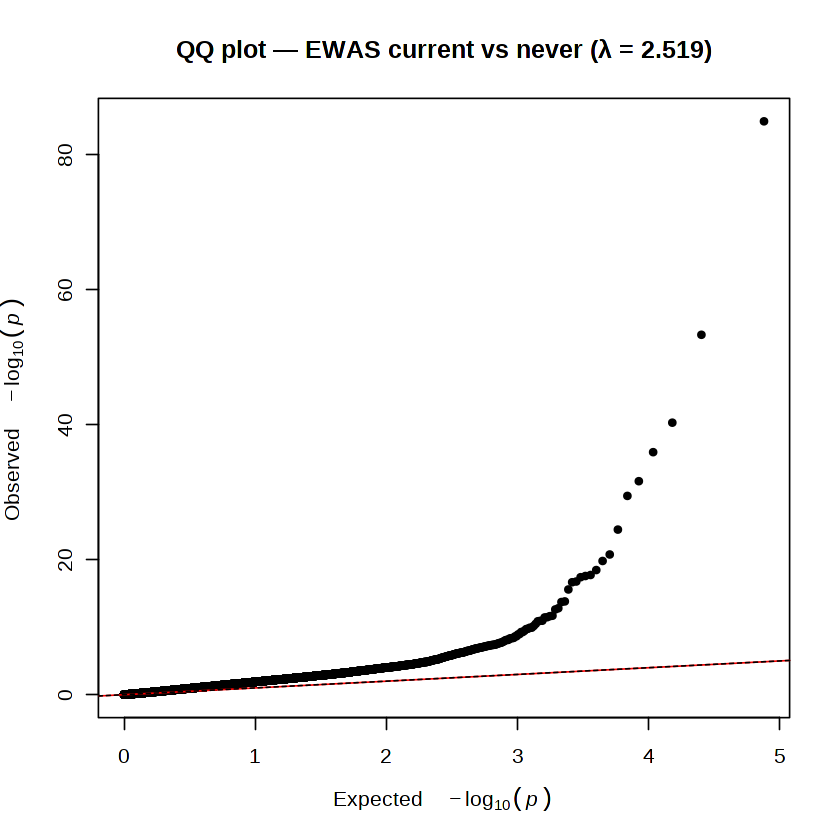

In [52]:
# Get p values
p <- results_table$p.value

# Compute lambda
p <- p[!is.na(p) & is.finite(p)]
p[p == 0] <- .Machine$double.xmin           # avoid Inf in qchisq
chisq <- qchisq(1 - p, df = 1)              # observed chi^2
lambda <- median(chisq) / qchisq(0.5, 1)    # genomic inflation

# Plot QQ
qq(p, main = sprintf("QQ plot — EWAS current vs never (λ = %.3f)", lambda))
abline(0, 1, lty = 2)  # reference line (optional)


**Comment:**

Our λ ≈ 2.5 is high—much higher than the ~1.0 you’d hope for in a well-calibrated genome-wide test. In a real study this could signal unmodelled confounding or technical effects (e.g., cell composition, batch/array, age/sex, population structure/relatedness, or outliers/collinearity).

In this practicum, the dataset is a small, curated subset enriched for smoking hits, so the p-value distribution is dominated by true associations. That naturally bends the QQ plot upward and inflates λ; here it’s not evidence of a problem.

Good practice: compare unadjusted, covariate-adjusted, and adjusted+SVA models (with a sensible cap on SVs). λ should usually decrease with appropriate adjustment. Use FDR to call discoveries; if you want a calibration check when many true effects are present, consider methods like bacon rather than relying solely on raw λ.

### 3.3.3 Significant CpGs

We focus on CpGs that pass a multiple-testing threshold—here we’ll use **FDR < 0.05**. These are the sites most likely to show a real association between Smoking (current vs never) and methylation.

How to read the effect:
- **Positive effect**: higher methylation in current smokers vs never (hypermethylation).
- **Negative effect**: lower methylation in current smokers vs never (hypomethylation).



In [53]:
fdr_sig_results <- results_table[!is.na(results_table$fdr) & results_table$fdr < 0.05, , drop = FALSE]
head(fdr_sig_results)

,p.value,fdr,p.holm,t.statistic,coefficient,coefficient.ci.high,coefficient.ci.low,coefficient.se,n,chromosome,position
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
cg03274069,1.440379e-05,0.0028541997,0.54236017,4.454606,0.04254537,0.061386022,0.023704724,0.009550872,188,chrX,153906245
cg12901451,6.400533e-04,0.0291466876,1.00000000,3.473677,0.01808667,0.028359335,0.007814002,0.005206780,184,chrX,48761757
cg20313902,1.620678e-03,0.0467171137,1.00000000,3.198615,0.01554955,0.025139331,0.005959771,0.004861338,188,chrX,153409698
cg00246451,1.330087e-05,0.0027354975,0.50089747,-4.473481,-0.00513440,-0.002870293,-0.007398507,0.001147742,188,chr1,155979221
cg00279406,7.711736e-05,0.0085555659,1.00000000,-4.042339,-0.01207774,-0.006183798,-0.017971676,0.002987809,188,chr1,226737038
cg00541303,1.390344e-06,0.0004384451,0.05244796,-4.986791,-0.03227499,-0.019507730,-0.045042258,0.006472097,188,chr1,208789029


In [56]:
cat("Number of FDR-significant CpGs (FDR < 0.05):", nrow(fdr_sig_results), "\n")
cat("Positive effects (current > never):", sum(fdr_sig_results$coefficient > 0, na.rm = TRUE), "\n")
cat("Negative effects (current < never):", sum(fdr_sig_results$coefficient < 0, na.rm = TRUE), "\n")

Number of FDR-significant CpGs (FDR < 0.05): 1367 
Positive effects (current > never): 602 
Negative effects (current < never): 765 


**Comment:**
We identified 1,367 significant CpGs (FDR < 0.05) out of 37,842 tested (~3.6%). Among these, 602 (44.0%) show a positive effect—i.e., higher methylation in current smokers vs never—while 765 (56.0%) show a negative effect, indicating lower methylation in current smokers.

### 3.3.2 Volcano Plots
A volcano plot lets us to a look at the EWAS results quickly:
- x-axis: effect size (regression coefficient; current − never on the modeling scale, e.g., M-values).
  - Right side (positive) → higher methylation in current smokers.
  - Left side (negative) → lower methylation in current smokers.

* y-axis: statistical strength (−log10(p-value)); higher = more significant.

We add a horizontal line at our significance threshold (e.g., the p-value that corresponds to FDR < 0.05) and, optionally, vertical lines to mark a practical effect-size cutoff. Points in the upper right are significant hypermethylated CpGs; points in the upper left are significant hypomethylated CpGs.

We’ll also color the points by significance (e.g., red/blue for FDR < 0.05, grey otherwise) so significant CpGs stand out.

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."


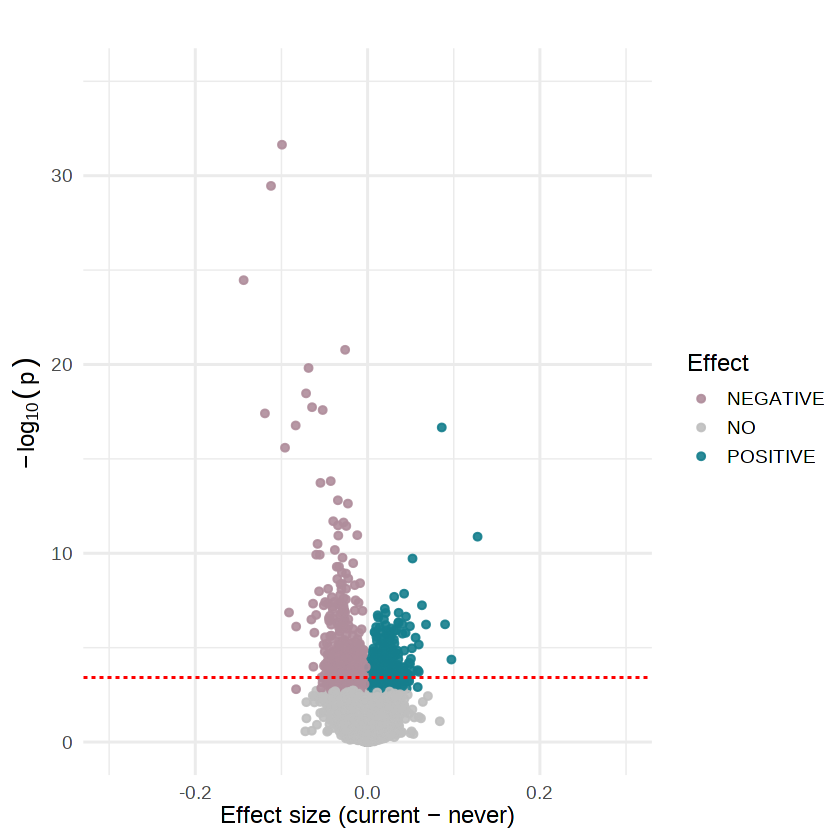

In [69]:
# Use full results table (all CpGs), not only the FDR<0.05 subset
res <- results_table

# Flag direction + significance
res$diffexpressed <- "NO"
res$diffexpressed[!is.na(res$fdr) & res$fdr < 0.05 & res$coefficient > 0] <- "POSITIVE"
res$diffexpressed[!is.na(res$fdr) & res$fdr < 0.05 & res$coefficient < 0] <- "NEGATIVE"

# Colors
mycolors <- c("POSITIVE" = "#157F8D", "NEGATIVE" = "#AF8D9B", "NO" = "grey")

# (Optional) draw a horizontal line at a p-value that corresponds to your chosen FDR cutoff.
# If you have a p-value threshold (e.g., 3.86e-04), keep it; otherwise omit the hline.
p_thresh <- 3.86e-04

p <- ggplot(res, aes(x = coefficient, y = -log10(p.value), color = diffexpressed)) +
  geom_point(size = 1.5, alpha = 0.9) +
  scale_colour_manual(values = mycolors, name = "Effect") +
  labs(title = "", x = "Effect size (current − never)", y = expression(-log[10](p))) +
  theme_minimal(base_size = 14) +
  theme(axis.title = element_text(color = "black"),
        plot.title = element_text(face = "bold", hjust = 0.5),
        legend.title = element_text(color = "black")) +
  xlim(c(-0.3, 0.3)) + ylim(c(0, 35)) +
  geom_hline(yintercept = -log10(p_thresh), linetype = "dashed", color = "red")

p

### 3.3.4 MANHATTAN PLOT

A Manhattan plot shows p-values across the genome:

x-axis: chromosomal position (hg19).

y-axis: significance (−log10(p)).

Dashed lines often mark epigenome-wide (e.g., p = 1×10⁻⁷ → y = 7) and suggestive (e.g., p = 1×10⁻⁵ → y = 5) thresholds.

Points high on the left/right arms of chromosomes highlight CpGs with strong associations; we can color epigenome-wide hits in red so they stand out.

In [ ]:
# Create a dataframe with chr, start, end and pval
df.current<-res.current.ord[,c("chromosome","position","p.value")]
head(df.current)

In [72]:
# PREPARE DATA FOR PLOTTING
# 1) start from full results
res <- results_table

# 2) keep rows with valid chr/pos/p
ok <- complete.cases(res[, c("chromosome","position","p.value")])
res <- res[ok, , drop = FALSE]

# 3) ensure 'chr' prefix
chr <- as.character(res$chromosome)
chr <- ifelse(grepl("^chr", chr, ignore.case = TRUE), chr, paste0("chr", chr))

# 4) build GRanges (use position ±1bp)
gr <- GRanges(
  seqnames = chr,
  ranges   = IRanges(start = as.integer(res$position),
                     end   = as.integer(res$position) + 1),
  pval     = res$p.value
)

# 5) colors by significance (optional)
cols <- ifelse(res$p.value < 1e-7, "red",
         ifelse(res$p.value < 1e-5, "orange", "grey"))
invisible(cols)  # avoid printing the vector

ERROR: Error in parse(text = input): <text>:17:1: unexpected symbol
16: # colors by significance (optional)
17: cols
    ^


In [ ]:
# plot
kp <- plotKaryotype(genome = "hg19", plot.type = 4)
kp <- kpAddChromosomeNames(kp, cex = 0.6, srt = 45)

# main scatter (Manhattan)
kp <- kpPlotManhattan(kp, data = gr, pval = mcols(gr)$pval, ymax = 10, col = cols)

# y-axis and reference lines
kp <- kpAxis(kp, ymin = 0, ymax = 10, cex = 0.8)
kpAbline(kp, h = 7, col = "red",    lty = 2)  # epigenome-wide (1e-7)
kpAbline(kp, h = 5, col = "orange", lty = 3)  # suggestive (1e-5)

###  Additional: Report meffil

Addtiionally meffil allows to create a report by
To explore the results, we will create a report using meffil.ewas.parameters() and meffil.ewas.summary() functions from meffil R package.

This report contains:

Sample characteristics
Covariate associations: Associations between the exposure variable (Smoking) and the covariates.
Lambdas and QQplots to examine inflation (none, all cov, sva)
Manhattan plots
Significant CpG sites. As threshold we will indicate FDR=0.05.
Specific CpGs Box plot: To observe the methylation differences between Never VS Current smokers, you can specify the CpGs that you are interested in. Today we will select our top significant CpG “cg05575921” that is annotated to AHRR gene and it is well known for its association with tabbacco.

In [ ]:
ewas.parameters <- meffil.ewas.parameters(max.plots = 1,model="sva", sig.threshold = 3.86e-04) #FDR (0.05) = p.value (3.86e-04)
candidate.site <- c("cg05575921")
ewas.summary <- meffil.ewas.summary(ewas.current,
                                    methyl.current,
                                    selected.cpg.sites=candidate.site,
                                    parameters=ewas.parameters)

# 3.4 Discussion-Interpretations:

* Which is the lambda of the unadjusted EWAS of current smoking? How does it change in adding covariates and surrogate variables?

* How many CpGs are associated with current smoking (after False Discovery Rate – FDR - correction) in the model adjusted by covariates and sva?

* How many of the FDR CpGs show higher methylation and how many lower methylation?

* Which is the top 1 CpG? In which chromosome is located?


Answers:
* Unadjusted: 2.44, adjusted for covariates: 2.22 and adjusted for covariates + sva: 1.51
* 289 164 show a negative effect and 125 show a positive effect
* cg05575921, it is located in chromosome 5

# 4 Downstream analyiss


also it cvan be done with online tools eFORGE is used to identify cell-type or tissue-type specific signals in epigenomic data by looking at the overlap between differentially methylated positions (DMPs) with DNase I hypersensitive sites (DHSs)

EWAS Catalog is a huge database of EWAS results. We can submit the names of our top CpGs to see the last published information about them

In [ ]:
library(IlluminaHumanMethylation450kanno.ilmn12.hg19)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(DOSE)

## 4.1 Annotation
Once we have obtained a list with the CpGs that are significant in our analysis, we need to locate them in the genome and try to know which structures surround them. The annotation consists in obtaining this information:

First we load the annotation from IlluminaHumanMethylation450kanno.ilmn12.hg19 R package and select the columns of interest

anot her option is to go to ...... (ebpage)

In [ ]:
data("IlluminaHumanMethylation450kanno.ilmn12.hg19")
annotation.table<- getAnnotation(IlluminaHumanMethylation450kanno.ilmn12.hg19)
dim(annotation.table)

In [ ]:
annotation.table<-as.data.frame(annotation.table[,c("chr","pos","strand",
                                                    "Name","Islands_Name",
                                                    "Relation_to_Island",
                                                    "UCSC_RefGene_Name",
                                                    "UCSC_RefGene_Group")])
head(annotation.table)

Merge our significant metaEWAS results with the annotation.



In [ ]:
metaEWAS.ann<-merge(metaEWAS.FDRsig, annotation.table,by.x="probe",by.y="Name")
metaEWAS.ann.ord<-metaEWAS.ann[order(metaEWAS.ann$p.fe),]

head(metaEWAS.ann.ord)

Create list of Genes for Enrichment and save list of FDR CpGs and FDR genes



In [ ]:
ann.genes.current<-metaEWAS.ann.ord$UCSC_RefGene_Name
ann.genes.current <- unlist(lapply(strsplit(ann.genes.current, ";"), unique))

## 4.2. Enrichment
he idea is to compare the list of genes that overlap our CpGs with the list of all the human genes that are anotated in specific databases. With this, we can see if our list of genes is a random subset or no.

First of all we convert Gene Symbols to Ensembl and Entrez Gene IDs to use them later

In [ ]:
ids <- bitr(ann.genes.current, fromType="SYMBOL", toType=c("ENSEMBL", "ENTREZID"), OrgDb="org.Hs.eg.db")
head(ids)

### 4.2.1. GO terms
We will first work with the Gene Ontology (GO) database, that allows us to see if a specific gene function is overrepresented in our gene list. We need to obtain the list of all human genes that are curated in GO.

In [ ]:
df = as.data.frame(org.Hs.egGO)
go_gene_list = unique(sort(df$gene_id))
ans.go <- enrichGO(gene = ids$ENTREZID,
                   ont = "BP",
                   OrgDb ="org.Hs.eg.db",
                   universe = go_gene_list,
                   readable=TRUE,
                   pvalueCutoff = 0.05)

tab.go <- as.data.frame(ans.go)
tab.go<- subset(tab.go, Count>5)
head(tab.go)

Finally we can perform different type of plots to see the results in a graphical way



In [ ]:
p1 <- barplot(ans.go, showCategory=10) +
  ggtitle('Never vs Current Smokers') +
  theme(plot.title = element_text(size = 18))
p1

In [ ]:
ans.go <- pairwise_termsim(ans.go)
p2 <- emapplot(ans.go, cex_label_category = 0.5, showCategory = 20) +
  ggtitle('Never vs Current Smokers') +
  theme(plot.title = element_text(size = 18))
p2

In [ ]:
p3 <- cnetplot(ans.go, circular = FALSE, colorEdge = TRUE, showCategory = 2)
p3

### 4.2.2 Reactome

In [ ]:
ans.react <- enrichPathway(gene=ids$ENTREZID,
                           pvalueCutoff = 0.05,
                           readable=TRUE)
tab.react <- as.data.frame(ans.react)
head(tab.react)

In this case, it exists a function that allows us to graphically investigate each of the pathwaysto see how the genes interact between them. We need to prepare a named list with the entrez gene ids and their fold change

In [ ]:
ids_coef_df <- merge(ids, metaEWAS.ann.ord[,c('UCSC_RefGene_Name', 'coef.fe')],
                     by.x = 'SYMBOL',
                     by.y='UCSC_RefGene_Name')

pathway_genes <- str_split(tab.react$geneID[[1]], '/')[[1]]

ids_coef_df <- ids_coef_df[ids_coef_df$SYMBOL %in% pathway_genes,]
ids_coef_df <- ids_coef_df[!duplicated(ids_coef_df$ENTREZID),]
ids_coef <- ids_coef_df$coef.fe
names(ids_coef) <- ids_coef_df$ENTREZID


p3 <- viewPathway("Platelet activation, signaling and aggregation",
            readable = TRUE,
            foldChange = ids_coef)
p3

If the net is too busy, we can re-plot keeping just the genes on our list (the coloured ones)

In [ ]:
p3$data <- p3$data[!is.na(p3$data$color),]
p3

t the end of the practice, please answer these questions:

Which is the top 1 enriched GO term in current smokers? and in former smokers?
Which are the enriched Reactome pathways in current smokers? and in former smokers?
Which are the enriched tissues in current smokers? and informer smokers?

For current smokers it is the regulation of neuron projection development. For former smokers it is embryonic organ development
For current smokers it is Platelet activation, signaling and aggregation. For former smokers it is Neuronal System
In current smokers they are blood and muscle. In former smokers they are blood and ESC

** RECAP **
Input: ExpressionSet with matrix of beta values + covariates dataframe (exposure, covariates, cells)
Output (for current and former):
- results dataframes (not adj, adj, adj and sva)
- report (descriptive, QQ plot and lambda, Manhattan plot, Box plots)
- Volcano plot and Manhattan plot